## Introduction¶
Most of the techniques we've seen in this course have been for numerical features. The technique we'll look at in this lesson, target encoding, is instead meant for categorical features. It's a method of encoding categories as numbers, like one-hot or label encoding, with the difference that it also uses the target to create the encoding. This makes it what we call a supervised feature engineering technique.

In [1]:
import pandas as pd

autos = pd.read_csv("autos.csv")

## Target Encoding¶
A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.

A simple and effective version is to apply a group aggregation from Lesson 3, like the mean. Using the Automobiles dataset, this computes the average price of each vehicle's make:

In [2]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


This kind of target encoding is sometimes called a mean encoding. Applied to a binary target, it's also called bin counting. (Other names you might come across include: likelihood encoding, impact encoding, and leave-one-out encoding.)

## Smoothing¶
An encoding like this presents a couple of problems, however. First are unknown categories. Target encodings create a special risk of overfitting, which means they need to be trained on an independent "encoding" split. When you join the encoding to future splits, Pandas will fill in missing values for any categories not present in the encoding split. These missing values you would have to impute somehow.

Second are rare categories. When a category only occurs a few times in the dataset, any statistics calculated on its group are unlikely to be very accurate. In the Automobiles dataset, the mercurcy make only occurs once. The "mean" price we calculated is just the price of that one vehicle, which might not be very representative of any Mercuries we might see in the future. Target encoding rare categories can make overfitting more likely.

A solution to these problems is to add smoothing. The idea is to blend the in-category average with the overall average. Rare categories get less weight on their category average, while missing categories just get the overall average.


Use Cases for Target Encoding

Target encoding is great for:

- High-cardinality features: A feature with a large number of categories can be troublesome to encode: a one-hot encoding would generate too many features and alternatives, like a label encoding, might not be appropriate for that feature. A target encoding derives numbers for the categories using the feature's most important property: its relationship with the target.

- Domain-motivated features: From prior experience, you might suspect that a categorical feature should be important even if it scored poorly with a feature metric. A target encoding can help reveal a feature's true informativeness.

## Example - MovieLens1M¶
The MovieLens1M dataset contains one-million movie ratings by users of the MovieLens website, with features describing each user and movie. This hidden cell sets everything up:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


With over 3000 categories, the Zipcode feature makes a good candidate for target encoding, and the size of this dataset (over one-million rows) means we can spare some data to create the encoding.

We'll start by creating a 25% split to train the target encoder.

In [6]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

The category_encoders package in scikit-learn-contrib implements an m-estimate encoder, which we'll use to encode our Zipcode feature.

In [8]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Let's compare the encoded values to the target to see how informative our encoding might be.


/var/folders/r9/ql9ltmp52sl7886y22z1hpx00000gn/T/ipykernel_3561/1844280021.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y, kde=False, norm_hist=True)


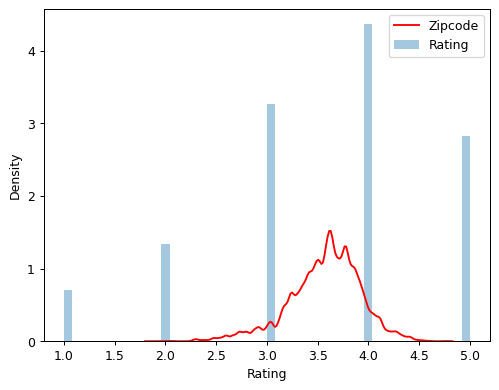

In [9]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

The distribution of the encoded Zipcode feature roughly follows the distribution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode to zipcode that our target encoding was able to capture useful information.